In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression

seed = 42
np.random.seed(seed)

Train Data Count: 27616


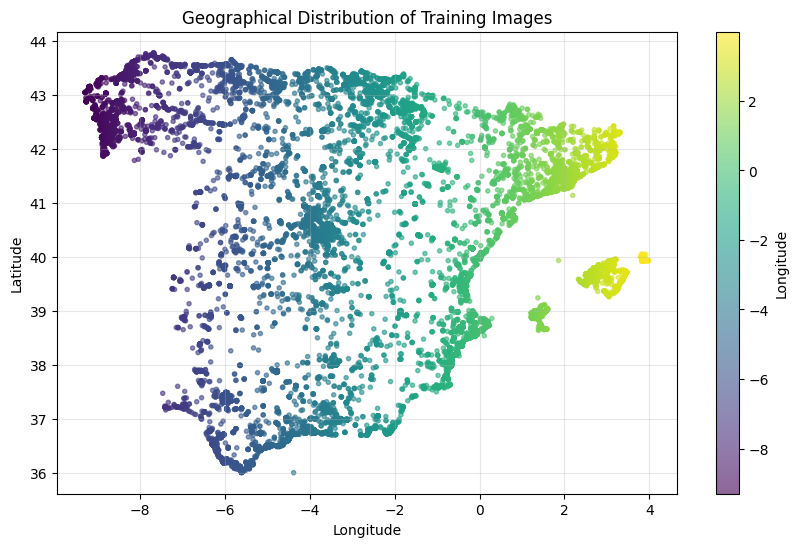

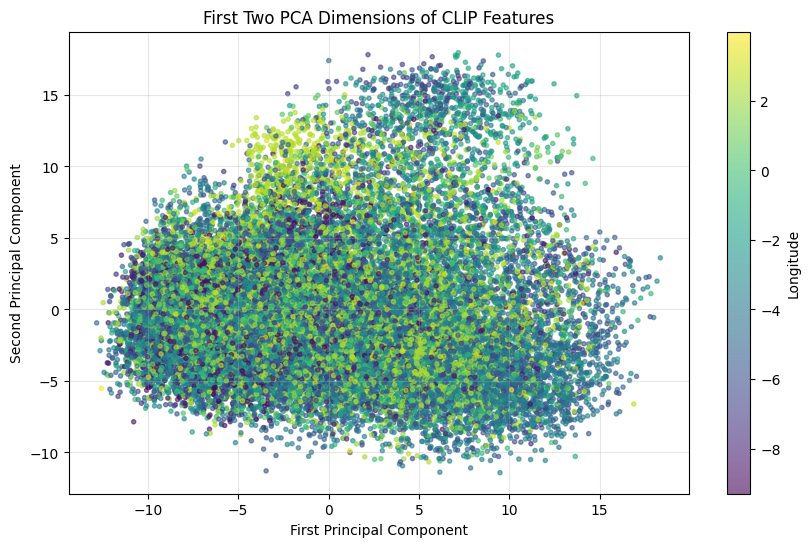

In [13]:
# Load and preprocess data
data = np.load('/content/drive/MyDrive/CS289/hw7/im2spain_data.npz')

train_features: np.ndarray = data['train_features']  # [N_train, dim] array
test_features: np.ndarray = data['test_features']    # [N_test, dim] array
train_labels: np.ndarray = data['train_labels']      # [N_train, 2] array of (lat, lon) coords
test_labels: np.ndarray = data['test_labels']        # [N_test, 2] array of (lat, lon) coords
train_files: np.ndarray = data['train_files']        # [N_train] array of strings
test_files: np.ndarray = data['test_files']          # [N_test] array of strings

# Data Information
print('Train Data Count:', train_features.shape[0])

# Plot the geographical distribution of images.
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_labels[:, 1], train_labels[:, 0],
                         c=train_labels[:, 1], marker='.', alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Training Images')
plt.grid(True, alpha=0.3)
plt.show()

# Proprocess data
scaler = StandardScaler()
transformed_train_features = scaler.fit_transform(train_features)
pca = PCA(n_components=2)
transformed_train_features = pca.fit_transform(transformed_train_features)

transformed_test_features = scaler.transform(test_features)
transformed_test_features = pca.transform(transformed_test_features)

# Plot pca features
plt.figure(figsize=(10, 6))
scatter = plt.scatter(transformed_train_features[:, 0], transformed_train_features[:, 1],
                         c=train_labels[:, 1], marker='.', alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Longitude')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("First Two PCA Dimensions of CLIP Features")
plt.grid(True, alpha=0.3)
plt.show()



In [14]:
# Distance constant
DEGREES_LAT_TO_MILES = 69  # 1 degree latitude = 69 miles
DEGREES_LON_TO_MILES = 52  # 1 degree longitude = 52 miles

# Find knn
def find_nearest_neighbors(target_filename, train_features, train_labels, train_files, k=3):
  target_idx = np.where(test_files == target_filename)
  if len(target_idx[0]) == 0:
    raise ValueError(f"Image {target_filename} not found in test set")

  target_idx = target_idx[0][0] # Extract the integer index
  target_features = transformed_test_features[target_idx:target_idx + 1] # Use transformed test features
  target_coords = test_labels[target_idx]

  knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
  knn.fit(train_features)

  distance, indices = knn.kneighbors(target_features)
  neighbor_info = []
  for i in range(k):
    neighbor_idx = indices[0][i]
    neighbor_filename = train_files[neighbor_idx]
    neighbor_coords = train_labels[neighbor_idx]
    neighbor_distance = distance[0][i]

    neighbor_info.append({
      'filename': neighbor_filename,
      'coordinates': neighbor_coords,
      'distance': neighbor_distance,
      'index': neighbor_idx
    })

    print(f"Neighbor {i+1}: {neighbor_filename}")
    print(f"  Coordinates: Lat {neighbor_coords[0]:.4f}, Lon {neighbor_coords[1]:.4f}")
    print(f"  Feature distance: {neighbor_distance:.4f}")

  return {
    'target_filename': target_filename,
    'target_coords': target_coords,
    'target_features': target_features,
    'neighbors': neighbor_info
  }

def displacement_error(coord1, coord2):
  lat_diff = (coord1[0] - coord2[0]) * DEGREES_LAT_TO_MILES
  lon_diff = (coord1[1] - coord2[1]) * DEGREES_LON_TO_MILES
  return np.sqrt(lat_diff**2 + lon_diff**2)

def calculate_mde(true_coords, pred_coords):
  errors = displacement_error(true_coords, pred_coords)
  return np.mean(errors)

target_image = '53633239060.jpg'
neighbor_results = find_nearest_neighbors(
    target_image,
    transformed_train_features, # Use transformed train features
    train_labels,
    train_files,
    k=3
  )

for i, neighbor in enumerate(neighbor_results['neighbors']):
    geo_distance = displacement_error(neighbor_results['target_coords'], neighbor['coordinates'])
    print(f"Neighbor {i+1} geographical distance: {geo_distance:.2f} miles")

Neighbor 1: 25977212713.jpg
  Coordinates: Lat 42.4546, Lon -6.0531
  Feature distance: 0.1496
Neighbor 2: 46944926254.jpg
  Coordinates: Lat 37.8779, Lon -4.7796
  Feature distance: 0.2434
Neighbor 3: 53629394250.jpg
  Coordinates: Lat 40.9605, Lon -5.6670
  Feature distance: 0.2743
Neighbor 1 geographical distance: 350.13 miles
Neighbor 2 geographical distance: 71.87 miles
Neighbor 3 geographical distance: 247.61 miles



Naive baseline Mean Displacement Error: 115.4 miles

Best k: 10 (MDE = 83.1 miles)


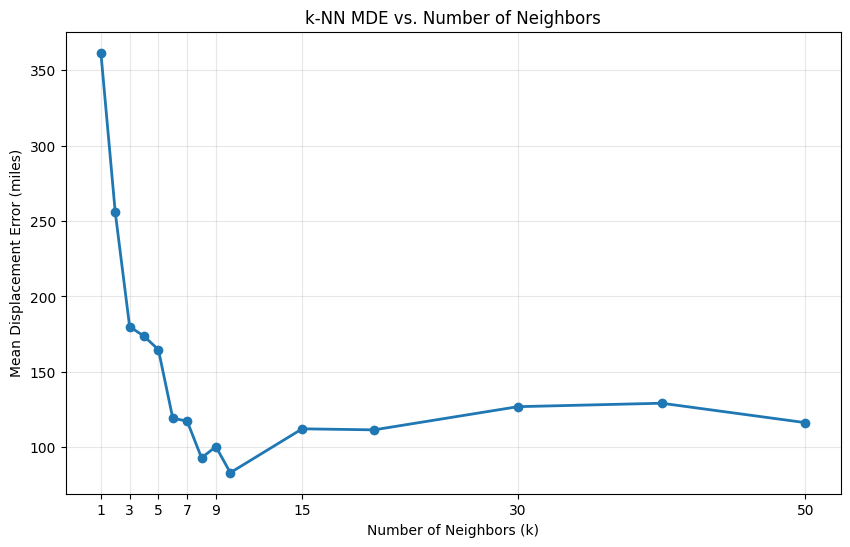

In [15]:
# Naive constant baseline
def naive_baseline_model(train_labels, test_labels):
  centroid = np.mean(train_labels, axis=0)
  predictions = np.tile(centroid, (len(test_labels), 1))
  mde = calculate_mde(test_labels, predictions)
  return predictions, mde

baseline_predictions, baseline_mde = naive_baseline_model(train_labels, test_labels)
print(f"\nNaive baseline Mean Displacement Error: {baseline_mde:.1f} miles")

# knn regression with grid search
def knn_regression_predict(train_features, train_labels, test_features, k):
  knn = NearestNeighbors(n_neighbors=k)
  knn.fit(train_features)

  _, indices = knn.kneighbors(test_features)
  predictions = np.zeros((len(test_features), 2))
  for i in range(len(test_features)):
    neighbor_coords = train_labels[indices[i]]
    predictions[i] = np.mean(neighbor_coords, axis=0)

  return predictions

def knn_grid_search(train_features, train_labels, test_features, test_labels,
                   k_values=None):
  if k_values is None:
    k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50]

  mde_values = []
  for k in k_values:
    predictions = knn_regression_predict(train_features, train_labels,
                                         test_features, k)
    mde = calculate_mde(test_labels, predictions)
    mde_values.append(mde)

  best_idx = np.argmin(mde_values)
  best_k = k_values[best_idx]
  best_mde = mde_values[best_idx]
  print(f"\nBest k: {best_k} (MDE = {best_mde:.1f} miles)")
  return k_values, mde_values, best_k, best_mde

# Run grid search
k_vals, mde_vals, best_k, best_mde = knn_grid_search(train_features, train_labels,
                                                     test_features, test_labels)

plt.figure(figsize=(10, 6))
plt.plot(k_vals, mde_vals, marker='o', linewidth=2, markersize=6)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Displacement Error (miles)')
plt.title("k-NN MDE vs. Number of Neighbors")
plt.grid(True, alpha=0.3)
plt.xticks(k_vals[::2])  # Show every other k value
plt.show()


Training with 1.0% of data...
Training with 5.0% of data...
Training with 10.0% of data...
Training with 20.0% of data...
Training with 30.0% of data...
Training with 40.0% of data...
Training with 50.0% of data...
Training with 60.0% of data...
Training with 70.0% of data...
Training with 80.0% of data...
Training with 90.0% of data...
Training with 100.0% of data...


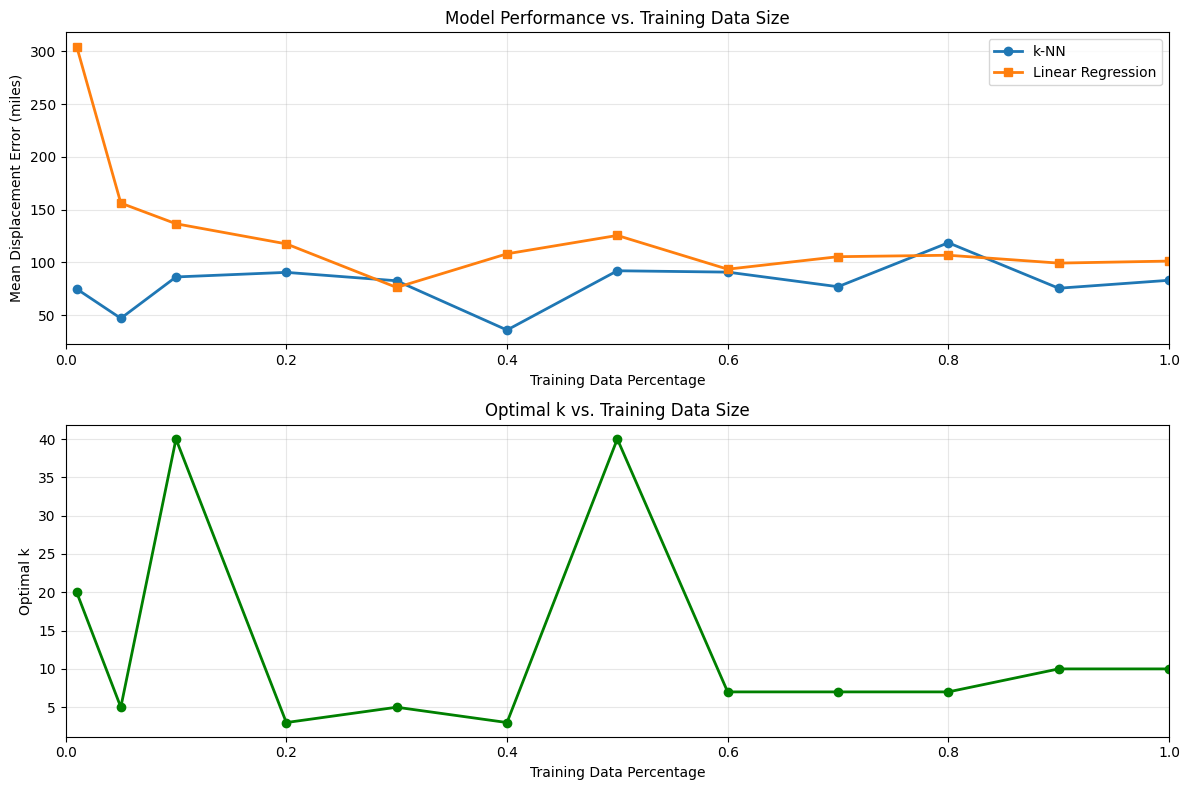

In [16]:
# Scaling curves - k-NN vs linear regression

def linear_regression_predict(train_features, train_labels, test_features):
  model = LinearRegression()
  model.fit(train_features, train_labels)
  predictions = model.predict(test_features)
  return predictions

def find_optimal_k_subset(train_features_subset, train_labels_subset,
                         test_features, test_labels, k_values=None):
  if k_values is None:
    # Adjust k_values based on subset size
    max_k = min(50, len(train_features_subset) - 1)
    k_values = [k for k in [1, 3, 5, 7, 10, 15, 20, 30, 40, 50] if k <= max_k]

  best_mde = float('inf')
  best_k = 1

  for k in k_values:
    if k >= len(train_features_subset):
      continue

    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(train_features_subset)
    distances, indices = knn.kneighbors(test_features)

    predictions = np.zeros((len(test_features), 2))
    for i in range(len(test_features)):
      neighbor_coords = train_labels_subset[indices[i]]
      predictions[i] = np.mean(neighbor_coords, axis=0)

    mde = calculate_mde(test_labels, predictions)

    if mde < best_mde:
      best_mde = mde
      best_k = k

  return best_k, best_mde

percentages = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
knn_mdes = []
linear_mdes = []
optimal_ks = []

for p in percentages:
  print(f"Training with {p*100:.1f}% of data...")
  n_samples = int(p * len(train_features))
  if n_samples == 0:
    n_samples = 1

  indices = np.random.choice(len(train_features), size=n_samples, replace=False)
  train_features_subset = train_features[indices]
  train_labels_subset = train_labels[indices]
  best_k, knn_mde = find_optimal_k_subset(train_features_subset, train_labels_subset,
                                        test_features, test_labels)
  knn_mdes.append(knn_mde)
  optimal_ks.append(best_k)
  linear_predictions = linear_regression_predict(train_features_subset, train_labels_subset,
                                              test_features)
  linear_mde = calculate_mde(test_labels, linear_predictions)
  linear_mdes.append(linear_mde)

plt.figure(figsize=(12, 8))

# Plot 1: MDE vs Training Data Percentage
plt.subplot(2, 1, 1)
plt.plot(percentages, knn_mdes, marker='o', linewidth=2, markersize=6, label='k-NN')
plt.plot(percentages, linear_mdes, marker='s', linewidth=2, markersize=6, label='Linear Regression')
plt.xlabel('Training Data Percentage')
plt.ylabel('Mean Displacement Error (miles)')
plt.title('Model Performance vs. Training Data Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Plot 2: Optimal k vs Training Data Percentage
if optimal_ks is not None:
    plt.subplot(2, 1, 2)
    plt.plot(percentages, optimal_ks, marker='o', linewidth=2, markersize=6, color='green')
    plt.xlabel('Training Data Percentage')
    plt.ylabel('Optimal k')
    plt.title('Optimal k vs. Training Data Size')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()